In [8]:
import wfdb
import numpy as np
import os
import matplotlib.pyplot as plt


In [2]:
import torch

In [23]:
def load_ludb_data(data_path, lead):
    records = []
    annotations = []
    
    for record_name in sorted(os.listdir(data_path)):
        if record_name.endswith(".dat"):
            record_id = record_name[:-4]
            lead_name = lead_map[lead]
            
            record = wfdb.rdrecord(os.path.join(data_path, record_id))
            lead_idx = record.sig_name.index(lead_name)
            
            selected_record = wfdb.rdrecord(os.path.join(data_path, record_id), channels=[lead_idx])
            records.append(selected_record.p_signal[:, 0])
            
            try:
                annotation = wfdb.rdann(os.path.join(data_path, record_id), lead_name)
                annotations.append(annotation)
            except FileNotFoundError:
                print(f"No annotation file found for {record_id}")
                continue

    return records, annotations





In [24]:
data_path = "/Users/aman/Downloads/ludb/data"
lead = 1
ecg_data, ecg_annotations = load_ludb_data(data_path, lead)


In [33]:
def create_single_mask(annotation, sig_len):
    mask = np.zeros(sig_len)
    wave_start, wave_category = None, None

    for i, symbol in enumerate(annotation.symbol):
        if symbol == "(":
            wave_start = annotation.sample[i]
        elif symbol == "p":
            if wave_start is not None:
                wave_category = 1
        elif symbol == "N":
            if wave_start is not None:
                wave_category = 2
        elif symbol == "t":
            if wave_start is not None:
                wave_category = 3
        elif symbol == ")":
            wave_end = annotation.sample[i]
            if wave_start is not None and wave_category is not None:
                mask[wave_start:wave_end] = wave_category
            wave_start, wave_category = None, None

    return mask

ecg_single_masks = [create_single_mask(ann, len(sig)) for sig, ann in zip(ecg_data, ecg_annotations)]





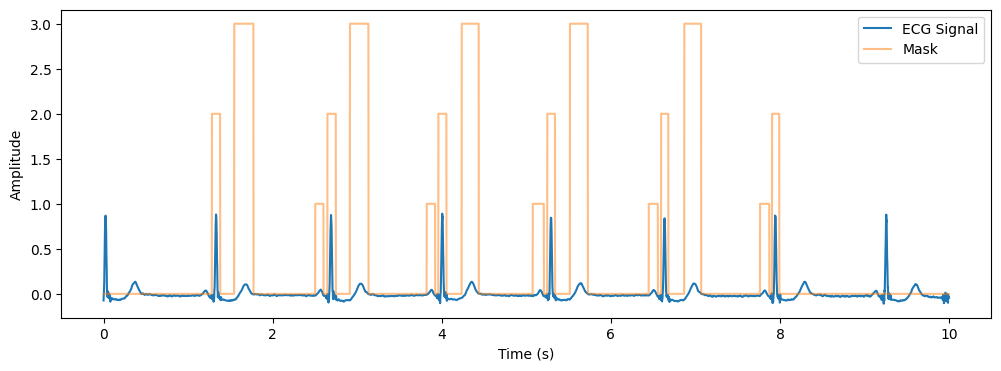

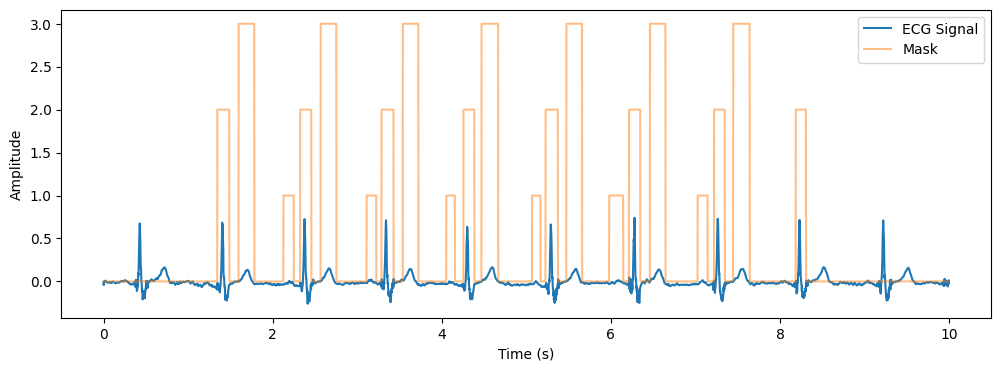

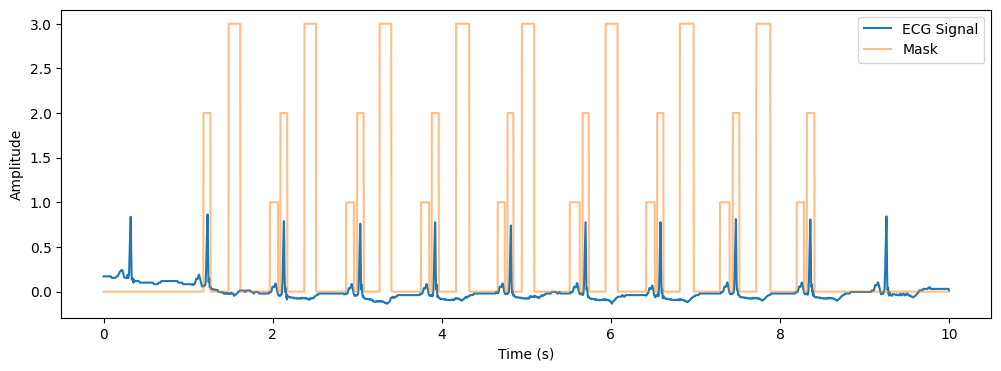

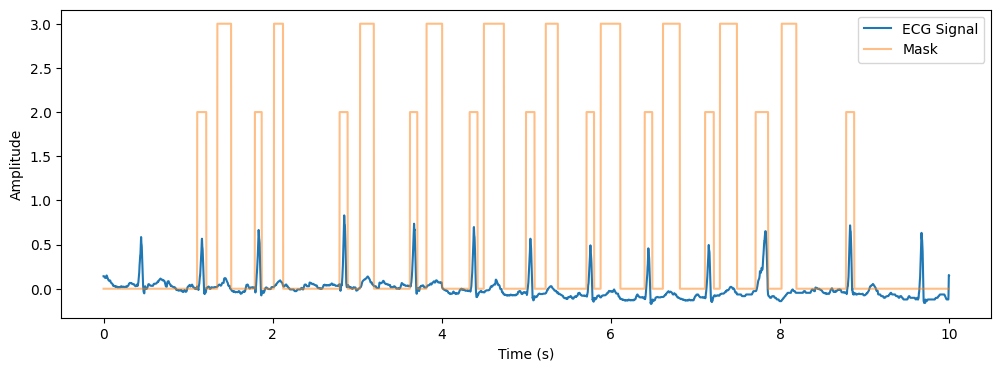

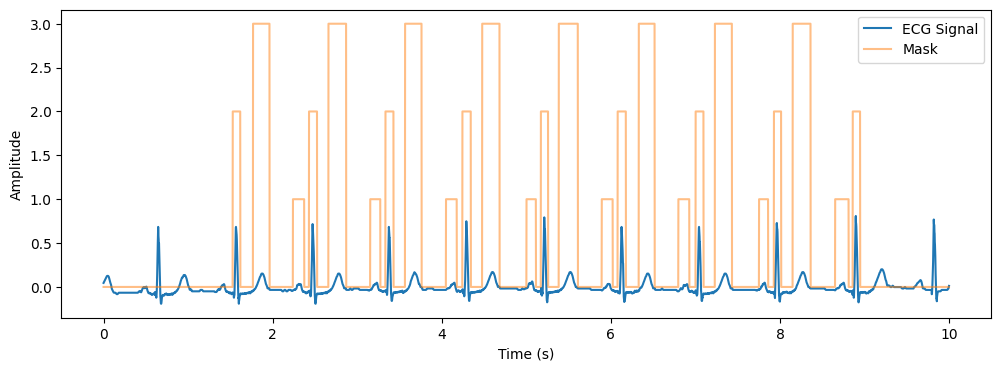

In [39]:
def plot_ecg_with_single_mask(ecg_signal, mask, duration, fs):
    time = np.arange(0, duration, 1/fs)
    
    plt.figure(figsize=(12, 4))
    
    plt.plot(time, ecg_signal, label="ECG Signal")
    plt.plot(time, mask, label="Mask", alpha=0.5)
    
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

# Plot a few ECG signals with their corresponding single masks
num_signals_to_plot = 5
duration = len(ecg_data[0]) / fs

for i in range(num_signals_to_plot):
    plot_ecg_with_single_mask(ecg_data[i], ecg_single_masks[i], duration, fs)



In [55]:
def zero_unannotated_regions(signal, mask):
    # Find the start and end indices of the annotated region
    start_idx = np.argmax(mask > 0)
    end_idx = len(mask) - np.argmax(mask[::-1] > 0)

    # Set the values before and after the annotated region to zero
    signal[:start_idx] = 0
    signal[end_idx:] = 0

    return signal

In [56]:
ecg_zeroed_data = []

for signal, mask in zip(ecg_data, ecg_single_masks):
    zeroed_signal = zero_unannotated_regions(signal, mask)
    ecg_zeroed_data.append(zeroed_signal)

In [53]:
import matplotlib.pyplot as plt

def plot_signal_and_mask(signal, mask):
    fig, ax = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

    ax[0].plot(signal)
    ax[0].set_title("Trimmed ECG Signal")
    ax[0].set_ylabel("Amplitude")

    ax[1].plot(mask)
    ax[1].set_title("ECG Mask")
    ax[1].set_xlabel("Time (samples)")
    ax[1].set_ylabel("Wave Category")

    plt.tight_layout()
    plt.show()


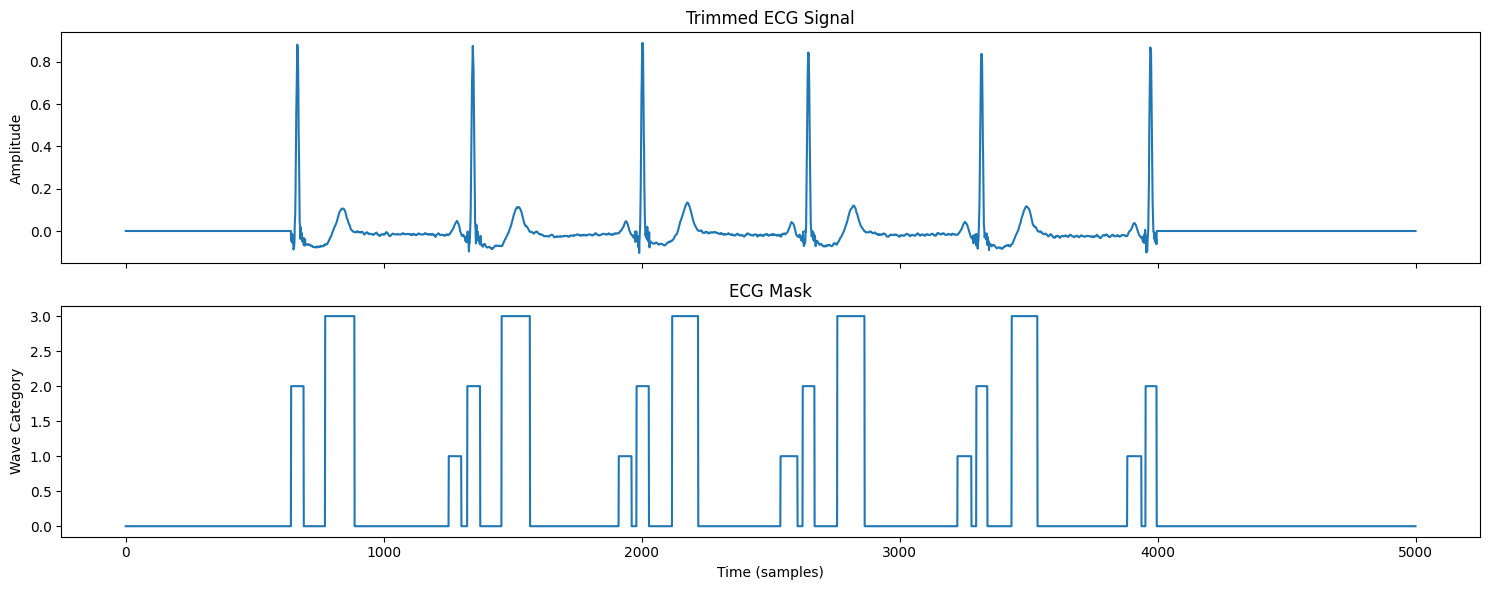

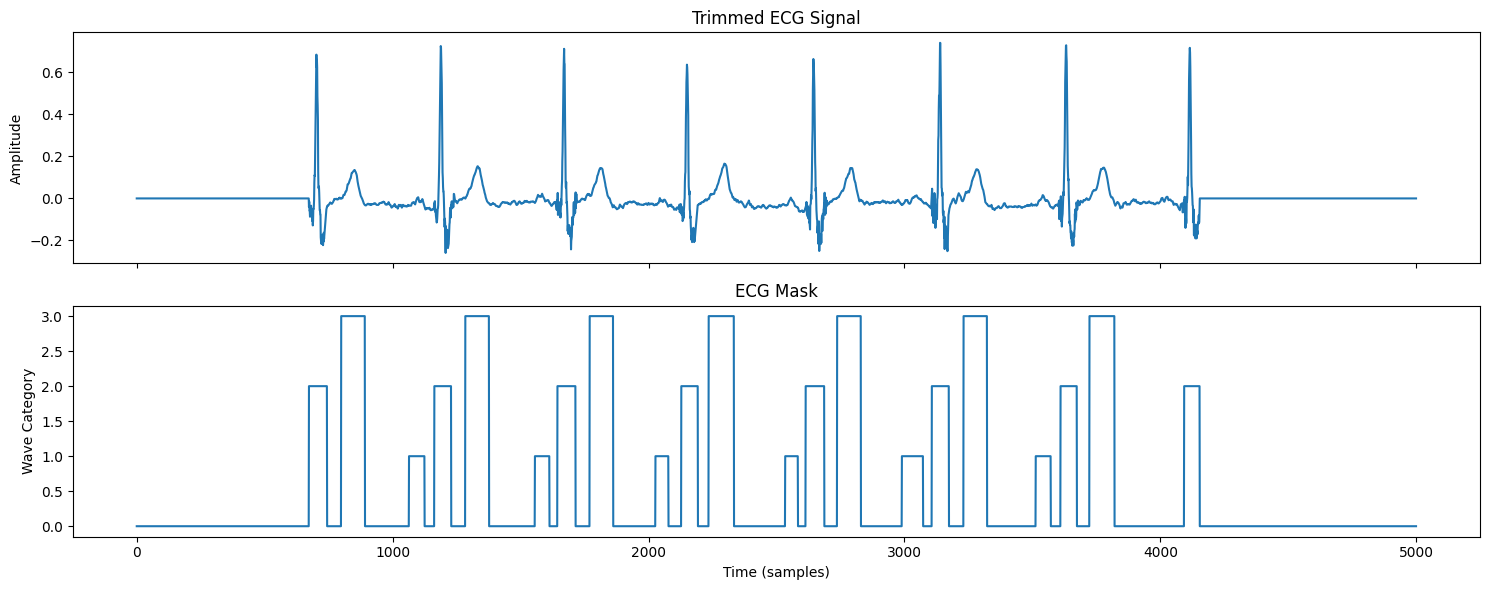

In [59]:
num_signals_to_plot = 2

for i in range(num_signals_to_plot):
    plot_signal_and_mask(ecg_zeroed_data[i], ecg_single_masks[i])


In [18]:
record_id = '1'
lead = 1
lead_name = lead_map[lead]

record = wfdb.rdrecord(os.path.join(data_path, record_id))
lead_idx = record.sig_name.index(lead_name)

selected_record = wfdb.rdrecord(os.path.join(data_path, record_id), channels=[lead_idx])
print(selected_record.__dict__)




{'record_name': '1', 'n_sig': 1, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 5000, 'base_time': None, 'base_date': None, 'comments': ['<age>: 51', '<sex>: F', '<diagnoses>:', 'Rhythm: Sinus bradycardia.', 'Electric axis of the heart: left axis deviation.', 'Left ventricular hypertrophy.', 'Left ventricular overload.', 'Non-specific repolarization abnormalities: posterior wall.'], 'sig_name': ['i'], 'p_signal': array([[-0.07342657],
       [-0.02855478],
       [ 0.01689977],
       ...,
       [-0.04079254],
       [-0.03671329],
       [-0.04195804]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['1.dat'], 'fmt': ['16'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [1716.0], 'baseline': [6], 'units': ['mV'], 'adc_res': [0], 'adc_zero': [0], 'init_value': [-120], 'checksum': [-32198], 'block_size': [0]}


In [21]:
annotation_ext = None
for ext in ['i']:   
    if os.path.exists(os.path.join(data_path, f"{record_id}.{ext}")):
        annotation_ext = ext
        break

if annotation_ext is not None:
    annotation = wfdb.rdann(os.path.join(data_path, record_id), annotation_ext)
    print(annotation.__dict__)
else:
    print(f"No annotation file found for {record_id}")


{'record_name': '1', 'extension': 'i', 'sample': array([ 641,  664,  690,  773,  840,  887, 1252, 1282, 1301, 1324, 1344,
       1374, 1457, 1519, 1567, 1911, 1938, 1961, 1980, 2002, 2028, 2118,
       2176, 2219, 2538, 2581, 2604, 2624, 2645, 2670, 2758, 2820, 2864,
       3224, 3252, 3278, 3297, 3316, 3340, 3434, 3491, 3534, 3882, 3908,
       3937, 3953, 3971, 3996]), 'symbol': ['(', 'N', ')', '(', 't', ')', '(', 'p', ')', '(', 'N', ')', '(', 't', ')', '(', 'p', ')', '(', 'N', ')', '(', 't', ')', '(', 'p', ')', '(', 'N', ')', '(', 't', ')', '(', 'p', ')', '(', 'N', ')', '(', 't', ')', '(', 'p', ')', '(', 'N', ')'], 'subtype': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0]), 'chan': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0]), 'num': array([0, 0, 0

In [87]:
class ECGDataset(Dataset):
    def __init__(self, signals, masks):
        self.signals = signals
        self.masks = masks

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        signal = self.signals[idx]
        mask = self.masks[idx]

        # Add channel dimension to the signal
        signal = signal.unsqueeze(0)

        return signal.float(), mask.long()



In [88]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Convert lists to arrays for train_test_split
ecg_zeroed_data = np.array(ecg_zeroed_data)
ecg_single_masks = np.array(ecg_single_masks)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(ecg_zeroed_data, ecg_single_masks, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).long()

# Create TensorDatasets
train_dataset = ECGDataset(X_train_tensor, y_train_tensor)
test_dataset = ECGDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [93]:
for inputs, labels in train_loader:
    print("Input shape:", inputs.shape)
    print("Target shape:", labels.shape)
    break


Input shape: torch.Size([32, 1, 5000])
Target shape: torch.Size([32, 5000])


In [121]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.middle = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.output_conv = nn.Conv1d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        x3 = self.decoder(x2)
        x4 = self.output_conv(x3)

        return x4


# Create the U-Net model
in_channels = 1  # Since you have only one channel in your ECG signals
out_channels = len(np.unique(y_train))  # Number of unique classes in your mask
model = UNet(in_channels, out_channels)



In [124]:
class UNetWithPrint(UNet):
    def __init__(self, in_channels, out_channels):
        super(UNetWithPrint, self).__init__(in_channels, out_channels)

    def forward(self, x):
        print("Input shape:", x.shape)

        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)

        x_middle = self.middle(x4)

        x = self.decoder1(x_middle, x4)
        x = self.decoder2(x, x3)
        x = self.decoder3(x, x2)
        x = self.decoder4(x, x1)

        x = self.outc(x)

        print("Output shape:", x.shape)
        return x

# Create an instance of the UNetWithPrint model
model = UNetWithPrint(1, 4).to(device)


In [125]:
import torch.optim as optim
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of training epochs
num_epochs = 25

# Training loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    # Train the model
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    print(f'Training Loss: {train_loss:.4f}')
    
    # Test the model
    model.eval()
    running_loss = 0.0
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        running_loss += loss.item()

    test_loss = running_loss / len(test_loader)
    print(f'Test Loss: {test_loss:.4f}\n')


Epoch 1/25


  0%|          | 0/5 [00:00<?, ?it/s]

Input shape: torch.Size([32, 1, 5000])


AttributeError: 'UNetWithPrint' object has no attribute 'encoder1'

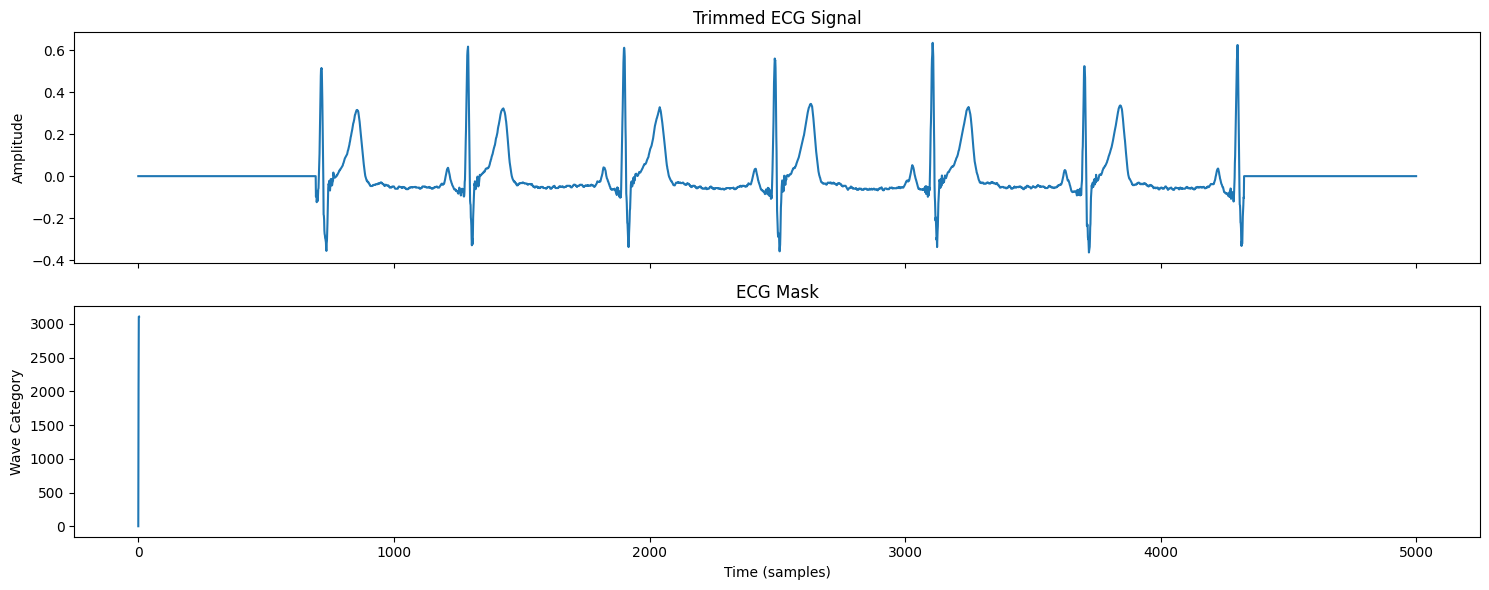

In [109]:
import matplotlib.pyplot as plt

def plot_signal_and_mask(signal, mask):
    fig, ax = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

    ax[0].plot(signal)
    ax[0].set_title("Trimmed ECG Signal")
    ax[0].set_ylabel("Amplitude")

    ax[1].plot(mask)
    ax[1].set_title("ECG Mask")
    ax[1].set_xlabel("Time (samples)")
    ax[1].set_ylabel("Wave Category")

    plt.tight_layout()
    plt.show()

# Get a sample from the test set
sample_idx = 20
sample_signal = X_test_tensor[sample_idx].unsqueeze(0).to(device)
true_mask = y_test_tensor[sample_idx]

# Get the predicted mask from the model
model.eval()
with torch.no_grad():
    predicted_output = model(sample_signal).cpu()

# Select the mask class with the highest value at each time step
predicted_mask = torch.argmax(predicted_output, dim=1).squeeze()

# Plot the ECG signal and predicted mask
plot_signal_and_mask(X_test[sample_idx], predicted_mask.numpy())




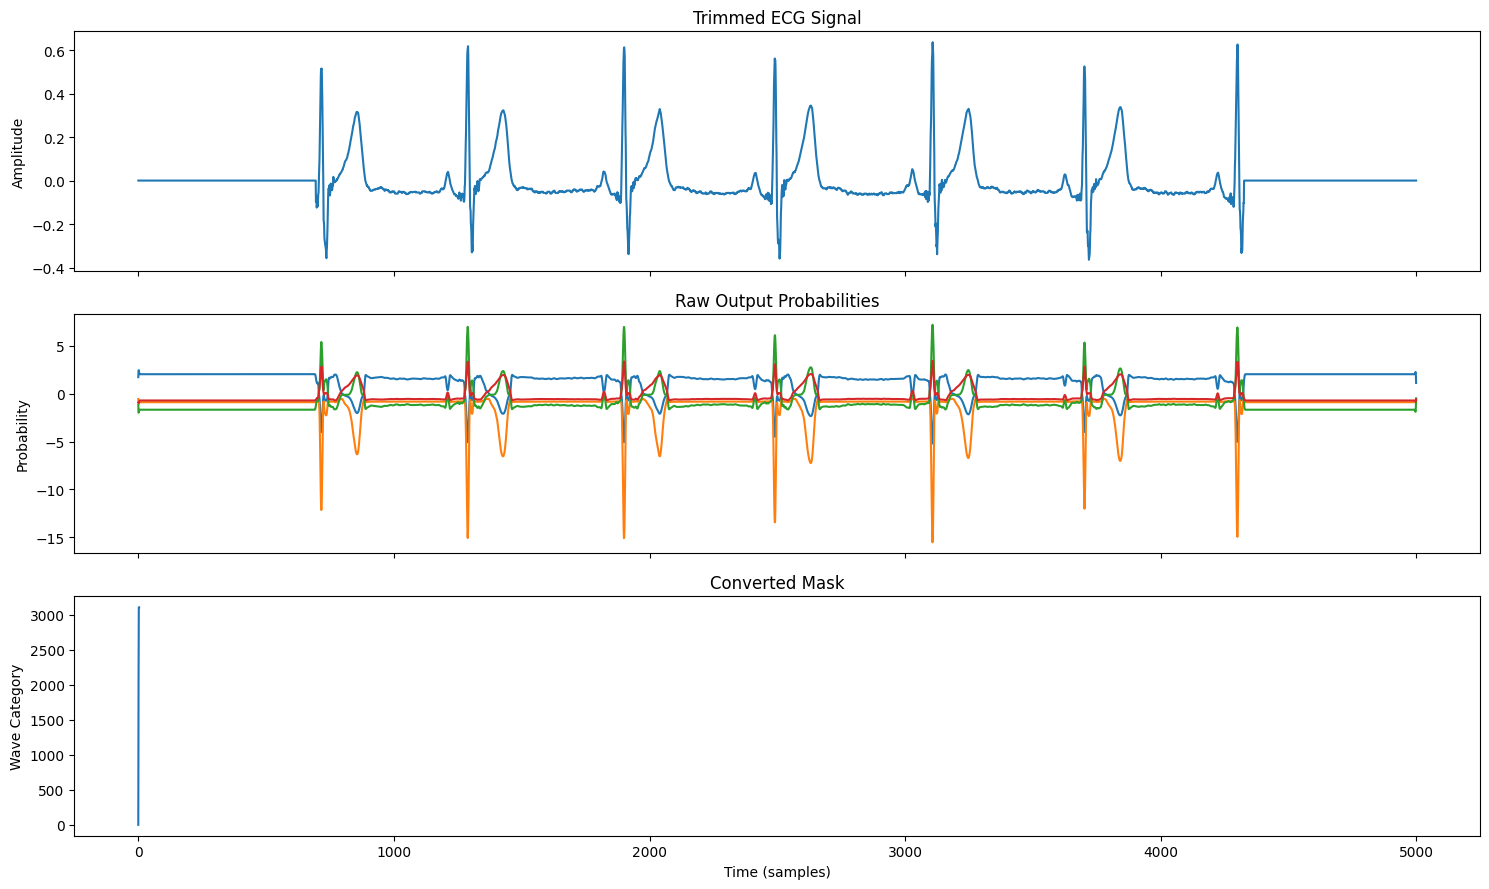

In [110]:
import matplotlib.pyplot as plt

def plot_signal_and_mask(signal, raw_output, converted_mask):
    fig, ax = plt.subplots(3, 1, figsize=(15, 9), sharex=True)

    ax[0].plot(signal)
    ax[0].set_title("Trimmed ECG Signal")
    ax[0].set_ylabel("Amplitude")

    ax[1].plot(raw_output.T)
    ax[1].set_title("Raw Output Probabilities")
    ax[1].set_ylabel("Probability")

    ax[2].plot(converted_mask)
    ax[2].set_title("Converted Mask")
    ax[2].set_xlabel("Time (samples)")
    ax[2].set_ylabel("Wave Category")

    plt.tight_layout()
    plt.show()

# Get a sample from the test set
sample_idx = 20
sample_signal = X_test_tensor[sample_idx].unsqueeze(0).to(device)
true_mask = y_test_tensor[sample_idx]

# Get the predicted mask from the model
model.eval()
with torch.no_grad():
    predicted_output = model(sample_signal).cpu()

# Select the mask class with the highest value at each time step
predicted_mask = torch.argmax(predicted_output, dim=1).squeeze()

# Plot the ECG signal, raw output probabilities, and converted mask
plot_signal_and_mask(X_test[sample_idx], predicted_output.squeeze().numpy(), predicted_mask.numpy())


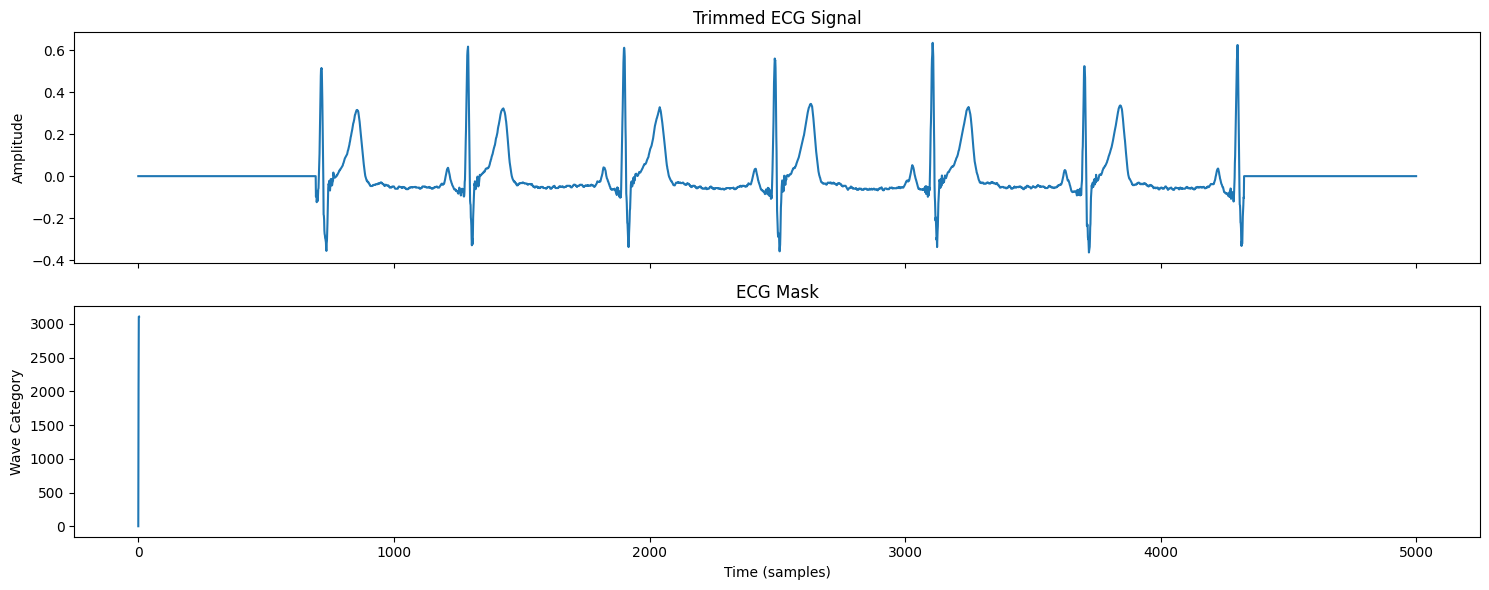

In [113]:
import matplotlib.pyplot as plt

def plot_signal_and_mask(signal, mask):
    fig, ax = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

    ax[0].plot(signal)
    ax[0].set_title("Trimmed ECG Signal")
    ax[0].set_ylabel("Amplitude")

    ax[1].plot(mask)
    ax[1].set_title("ECG Mask")
    ax[1].set_xlabel("Time (samples)")
    ax[1].set_ylabel("Wave Category")

    plt.tight_layout()
    plt.show()

# Get a sample from the test set
sample_idx = 20
sample_signal = X_test_tensor[sample_idx].unsqueeze(0).to(device)
true_mask = y_test_tensor[sample_idx]

# Get the predicted mask from the model
model.eval()
with torch.no_grad():
    predicted_output = model(sample_signal).cpu()

# Select the mask class with the highest value at each time step
predicted_mask = torch.argmax(predicted_output, dim=1).squeeze()

# Plot the ECG signal and predicted mask
plot_signal_and_mask(sample_signal.squeeze().cpu().numpy(), predicted_mask.numpy())


In [114]:
# Get a sample from the test set
sample_idx = 20
sample_signal = X_test_tensor[sample_idx].unsqueeze(0).to(device)
true_mask = y_test_tensor[sample_idx]

# Get the predicted mask from the model
model.eval()
with torch.no_grad():
    predicted_output = model(sample_signal).cpu()

print("Predicted output shape:", predicted_output.shape)
print("Predicted output:", predicted_output)


Predicted output shape: torch.Size([4, 5000])
Predicted output: tensor([[ 1.7343,  2.3917,  2.4649,  ...,  2.2746,  1.9534,  1.1287],
        [-0.5487, -0.9062, -1.0422,  ..., -0.8856, -0.8690, -0.7794],
        [-1.1592, -1.9857, -1.9539,  ..., -1.8868, -1.3901, -0.4813],
        [-0.9006, -0.8732, -0.9516,  ..., -0.8018, -0.7571, -0.5687]])
